# A quick demonstration of linear affine transformations in 3-D

In the previous chapter we looked at an example of a three dimensional NIfTI parcellation.  Towards the end of the chapter we visualized the parcellation, but noted that an apparent issue with the affine (or how it was being interpreted) led to an incorrect orientation for the visualization.  Lets explore this issue in a bit more depth.

Lets begin by loading the relevant nifti objects.

In [1]:
import nibabel as nib
#this code ensures that we can navigate the WiMSE repo across multiple systems
import subprocess
import os
#get top directory path of the current git repository, under the presumption that 
#the notebook was launched from within the repo directory
gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

#move to the top of the directory
os.chdir(gitRepoPath)

#establish path to new nifti file
newAtlasPath=os.path.join(gitRepoPath,'exampleData','renumberedAtlas.nii.gz')   
#load it as an object
atlasImg = nib.load(newAtlasPath)

#establish path to t1
t1Path=os.path.join(gitRepoPath,'exampleData','t1.nii.gz')   

#import the data
t1img = nib.load(t1Path)

Lets take a quick look at our to remind us of the source T1 orientation and the associated parcellation.  If everything is oriented appropriately the leftmost image will be a coronal slice (as viewed from the posterior), the middle image will be a sagital slice as viewed from the right, and the rightmost will be an axial slice as viewed from above.

We are a

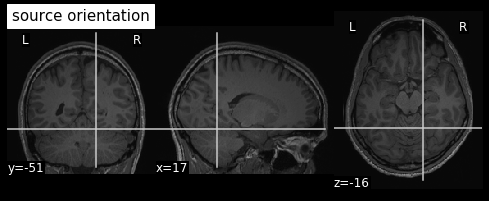

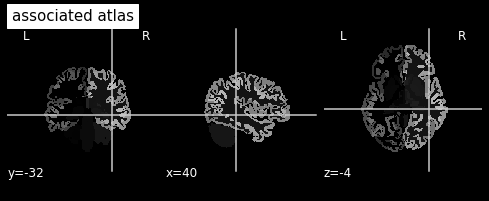

In [2]:
from nilearn import plotting
import matplotlib

%matplotlib inline

plotting.plot_anat(t1img, title="source orientation")

plotting.plot_anat(atlasImg, title="associated atlas")

This appears to be fine.  As an added bonus, we can determine from the coloring of the atlas plot whether or not it has an X-flip.  How?  Note that the cortical areas in the left hemisphere are labeled starting in 11,000, while cortical areas in the right hemisphere are labeled starting in 12,000, and that our coloring scheme ranges from black at 0 all the way to gray/white at the highest value.  Because the color of the right hemisphere is brighter, we can infer that the numbers are higher than in the left hemisphere, and thus the labels are on the appropriate side.

However, there appears to be something off when viewing the atlas interactively.

In [3]:
from niwidgets import NiftiWidget

atlas_widget = NiftiWidget(newAtlasPath)

atlas_widget.nifti_plotter(colormap='nipy_spectral')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=127, continuous_update=False, description='x', max=255), IntSlider(value…

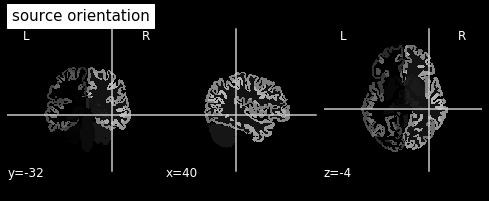

In [4]:
from nilearn import plotting
plotting.plot_anat(atlasImg, title="source orientation")

In [5]:
#multiDimOverlayPlot(t1Resampled,atlasImg,132,132,132)
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider

def rotateAndPlot(xRotation,yRotation,zRotation):
    import scipy
    from nilearn import plotting
    import nibabel as nib
    import numpy as np
    import math
    
    atlasData = atlasImg.get_fdata()
    atlasAffine=atlasImg.affine
   
    atlasAffine3=atlasAffine[0:3,0:3]
    
    atlasData=scipy.ndimage.rotate(atlasData,xRotation,mode='nearest',axes=(1,2))
    xRotationMatrix=[[1,0,0], \
                     [0,math.cos(xRotation*(math.pi/180)),-math.sin(xRotation*(math.pi/180))], \
                     [0,math.sin(xRotation*(math.pi/180)),math.cos(xRotation*(math.pi/180))]]

    
    atlasData=scipy.ndimage.rotate(atlasData,yRotation,mode='nearest',axes=(0,2))
    yRotationMatrix=[[math.cos(yRotation*(math.pi/180)), 0,math.sin(yRotation*(math.pi/180))],\
                     [0,1,0], \
                     [-math.sin(yRotation*(math.pi/180)),0,math.cos(yRotation*(math.pi/180))]]

    
    atlasData=scipy.ndimage.rotate(atlasData,zRotation,mode='nearest',axes=(0,1))
    zRotationMatrix=[[math.cos(zRotation*(math.pi/180)),-math.sin(zRotation*(math.pi/180)),0], \
                     [math.sin(zRotation*(math.pi/180)),math.cos(zRotation*(math.pi/180)),0], \
                     [0,0,1]]

    
    atlasAffine[0:3,0:3]=atlasAffine3.dot(xRotationMatrix).dot(yRotationMatrix).dot(zRotationMatrix)
  
    #print(atlasAffine)
    #establish path to new nifti file
    newHeader=atlasImg.header.copy()
    newHeader.set_sform(atlasAffine)

    #store the modified atlas data in a nifti object
    rotatedAtlasNifti=nib.Nifti1Image(atlasData, affine=atlasAffine, header=newHeader)  
    #save the object down
    #nib.save(rotatedAtlasNifti, rotatedAtlasPath)
    print(rotatedAtlasNifti.affine)
    #plotting.plot_anat(rotatedAtlasNifti, title="rotated atlas")
    return rotatedAtlasNifti
    
def rotateAndPlotWrapper(xRotation,yRotation,zRotation):
    import scipy
    from nilearn import plotting
    import nibabel as nib
    import numpy as np
    
    import subprocess
    import os
    #get top directory path of the current git repository, under the presumption that 
    #the notebook was launched from within the repo directory
    gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

    #move to the top of the directory
    os.chdir(gitRepoPath)
    

    
    rotatedAtlasNifti=rotateAndPlot(xRotation,yRotation,zRotation)
    
    rotatedAtlasPath=os.path.join(gitRepoPath,'exampleData','rotatedAtlas.nii.gz') 
    
    nib.save(rotatedAtlasNifti, rotatedAtlasPath)
    
    plotting.plot_anat(atlasImg, title="source orientation")
    plotting.plot_anat(rotatedAtlasNifti, title="rotated atlas")
    
interact(rotateAndPlotWrapper, \
         xRotation=IntSlider(min=0, max=360, step=90,continuous_update=False),  \
         yRotation=IntSlider(min=0, max=360, step=90,continuous_update=False), \
         zRotation=IntSlider(min=0, max=360, step=90,continuous_update=False)
         )

interactive(children=(IntSlider(value=0, continuous_update=False, description='xRotation', max=360, step=90), …

<function __main__.rotateAndPlotWrapper(xRotation, yRotation, zRotation)>

In [6]:
#rotatedAtlasPath=os.path.join(gitRepoPath,'exampleData','rotatedAtlas.nii.gz') 
 
#rotatedAtlasNifti = nib.load(rotatedAtlasPath)
    
#get affine from atlas
#atlasImgAff=rotatedAtlasNifti.affine
%matplotlib inline

    
import nilearn
t1Resampled=nilearn.image.resample_img(t1img,target_affine=atlasImg.affine,target_shape=atlasImg.shape)


def fig2Img(figure2convert):
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    from matplotlib.figure import Figure
    import matplotlib
    import numpy as np

    #canvas = FigureCanvas(figure2convert)
    ax = figure2convert.gca()
    ax.axis('off')
    figure2convert.tight_layout(pad=0)

    # To remove the huge white borders
    ax.margins(0)
    
    # draw the canvas, cache the renderer
    figure2convert.canvas.draw()       

    image_from_plot = np.frombuffer(figure2convert.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(figure2convert.canvas.get_width_height()[::-1] + (3,))

    return image_from_plot
    
def multiDimOverlayPlot(xSlice,ySlice,zSlice):
    #import dipy regtools
    from dipy.viz import regtools 
    #import matplotlib functions

    image1=t1Resampled
    image2=atlasImg
    
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import imshow

    sagitalFig=regtools.overlay_slices(image1.get_fdata(),image2.get_fdata(),slice_index=xSlice, slice_type=0)
    coronalFig=regtools.overlay_slices(image1.get_fdata(),image2.get_fdata(),slice_index=ySlice, slice_type=1)
    axialFig=regtools.overlay_slices(image1.get_fdata(),image2.get_fdata(),slice_index=zSlice, slice_type=2)
   
    
#multiDimOverlayPlot(t1Resampled,atlasImg,132,132,132)
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider

interact(multiDimOverlayPlot, \
         xSlice=IntSlider(min=0, max=256, step=1,continuous_update=False),  \
         ySlice=IntSlider(min=0, max=256, step=1,continuous_update=False), \
         zSlice=IntSlider(min=0, max=256, step=1,continuous_update=False)
         )

/Users/plab/anaconda/envs/currpy/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


interactive(children=(IntSlider(value=0, continuous_update=False, description='xSlice', max=256), IntSlider(va…

<function __main__.multiDimOverlayPlot(xSlice, ySlice, zSlice)>